In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, sampler
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
Random_seed =1
torch.backends.cudnn.enabled = False
torch.manual_seed(Random_seed)

In [ ]:
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()

In [ ]:
train_loader = DataLoader(datasets.MNIST(root='data',train=True,transform = train_transform,download=True),batch_size=32,num_workers=2, shuffle=True)
test_loader = DataLoader(datasets.MNIST(root='data',train=False,transform = test_transform,download=True),batch_size=32,num_workers=2, shuffle=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
for images, labels in train_loader:
  print(images.size())
  print(labels.size())
  print(labels[:10])
  break

torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor([4, 8, 8, 6, 7, 1, 0, 7, 1, 8])


In [ ]:
for val_img,val_label in test_loader:
  print(val_img.size())
  print(val_label.size())
  break

torch.Size([32, 1, 28, 28])
torch.Size([32])


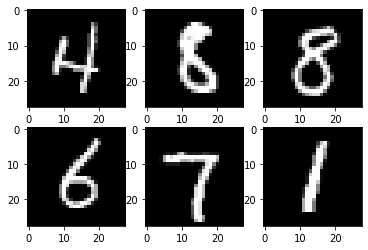

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(images[i][0],cmap='gray',interpolation="None")


In [ ]:
class Reshape(nn.Module):
  def __init__(self,*args) -> None:
      super().__init__()
      self.shape =args

  def forward(self,x):
    return x.view(self.shape)

class Trim(nn.Module):
  def __init__(self,*args):
      super().__init__()
      
  def forward(self,x):
    return x[:,:,:28,:28]


In [ ]:
from torch.nn.modules.activation import LeakyReLU
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1,32,kernel_size=(3,3),stride=(1,1),padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(32,64,kernel_size=(3,3),stride=(2,2),padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64,64,kernel_size=(3,3),stride=(2,2),padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64,64,kernel_size=(3,3),stride=(1,1),padding=1),
        nn.Flatten(),
        nn.Linear(64*7*7, 2)

    )

    self.decoder = nn.Sequential(
        torch.nn.Linear(2,64*7*7),
        Reshape(-1,64,7,7),
        nn.ConvTranspose2d(64,64,stride=(1,1),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64,64,stride=(2,2),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64,32,stride=(2,2),kernel_size=(3,3),padding=0),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(32,1,stride=(1,1),kernel_size=(3,3),padding=0),
        Trim(),
        nn.Sigmoid()

    )

  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [ ]:
DEVICE = torch.device('cuda:0')
model = Autoencoder()
model.to(DEVICE)

from torchsummary import summary
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         LeakyReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         LeakyReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]          36,928
           Flatten-8                 [-1, 3136]               0
            Linear-9                    [-1, 2]           6,274
           Linear-10                 [-1, 3136]           9,408
          Reshape-11             [-1, 64, 7, 7]               0
  ConvTranspose2d-12             [-1, 64, 7, 7]          36,928
        LeakyReLU-13             [-1, 64, 7, 7]               0
  ConvTranspose2d-14           [-1, 64,

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
from torch import optim
import time

def compute_accuracy(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

def compute_epoch_loss_classifier(model, data_loader, loss_fn, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)
            logits = model(features)
            loss = loss_fn(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
    
def train_autoencoder(num_epochs,model,optimizer,device, train_loader,
                      loss_fn =None, 
                      logging_interval= 100,
                      skip_epoch_stats =False,
                      save_model = None):
  
  log_dict = {'train_loss_per_batch': [],
                'train_loss_per_epoch': []}

  if loss_fn is None:
    loss_fn = F.mse_loss

  start_time = time.time()
  for epoch in range(num_epochs):

      model.train()
      for batch_idx, (features, _) in enumerate(train_loader):

          features = features.to(device)

          # FORWARD AND BACK PROP
          logits = model(features)
          loss = loss_fn(logits, features)
          optimizer.zero_grad()

          loss.backward()

          # UPDATE MODEL PARAMETERS
          optimizer.step()

          # LOGGING
          log_dict['train_loss_per_batch'].append(loss.item())
          
          if not batch_idx % logging_interval:
              print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                    % (epoch+1, num_epochs, batch_idx,
                        len(train_loader), loss))
      if not skip_epoch_stats:
            model.eval()
            
            with torch.set_grad_enabled(False):  # save memory during inference
                
                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_loss_per_epoch'].append(train_loss.item())

      print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
  '''if save_model is not None:
        torch.save(model.state_dict(), save_model)'''
    
  return log_dict

    

In [ ]:

from torch import cuda

DEVICE = torch.device('cuda:0')
print('Device:', DEVICE)
log_dict = train_autoencoder(num_epochs=10, model=model, 
                                optimizer=optimizer, device=DEVICE, 
                                train_loader=train_loader,
                                skip_epoch_stats=True,
                                logging_interval=250)

Device: cuda:0
Epoch: 001/010 | Batch 0000/1875 | Loss: 0.0527
Epoch: 001/010 | Batch 0250/1875 | Loss: 0.0460
Epoch: 001/010 | Batch 0500/1875 | Loss: 0.0509
Epoch: 001/010 | Batch 0750/1875 | Loss: 0.0527
Epoch: 001/010 | Batch 1000/1875 | Loss: 0.0482
Epoch: 001/010 | Batch 1250/1875 | Loss: 0.0448
Epoch: 001/010 | Batch 1500/1875 | Loss: 0.0453
Epoch: 001/010 | Batch 1750/1875 | Loss: 0.0440
Time elapsed: 0.56 min
Epoch: 002/010 | Batch 0000/1875 | Loss: 0.0475
Epoch: 002/010 | Batch 0250/1875 | Loss: 0.0398
Epoch: 002/010 | Batch 0500/1875 | Loss: 0.0496
Epoch: 002/010 | Batch 0750/1875 | Loss: 0.0479
Epoch: 002/010 | Batch 1000/1875 | Loss: 0.0435
Epoch: 002/010 | Batch 1250/1875 | Loss: 0.0441
Epoch: 002/010 | Batch 1500/1875 | Loss: 0.0427
Epoch: 002/010 | Batch 1750/1875 | Loss: 0.0427
Time elapsed: 1.12 min
Epoch: 003/010 | Batch 0000/1875 | Loss: 0.0442
Epoch: 003/010 | Batch 0250/1875 | Loss: 0.0458
Epoch: 003/010 | Batch 0500/1875 | Loss: 0.0465
Epoch: 003/010 | Batch 0750

In [ ]:
import numpy as np

def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

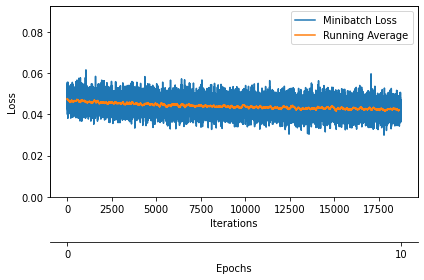

In [ ]:
NUM_EPOCHS = 10
plot_training_loss(log_dict['train_loss_per_batch'], NUM_EPOCHS)
plt.show()

In [ ]:
def plot_generated_images(data_loader, model, device, 
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):

    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                             sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (features, _) in enumerate(data_loader):
        
        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]
        
        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(features)[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')


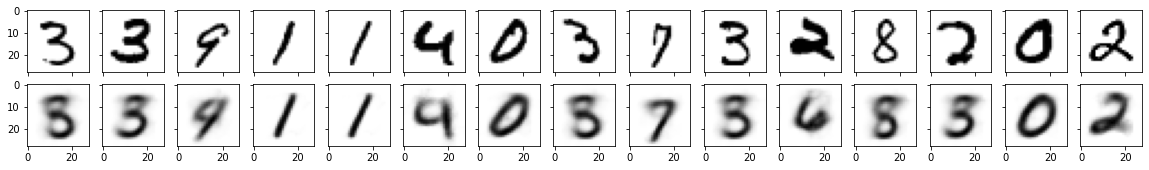

In [ ]:
plot_generated_images(data_loader=train_loader, model=model, device=DEVICE)   

In [ ]:
def plot_latent_space_with_labels(num_classes, data_loader, model, device):
    d = {i:[] for i in range(num_classes)}

    model.eval()
    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)
            embedding = model.encoder(features)
            #print("embedding",embedding.size())
            #print(embedding)
            
            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    #print('i',i)
                    #print('mak',mask)
                    #print('tragets',targets[20])
                    #print(embedding[mask].size())
                    d[i].append(embedding[mask].to('cpu').numpy())
            
    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()

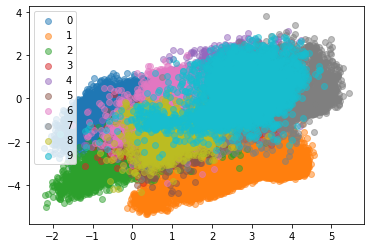

In [ ]:
import matplotlib.colors as mcolors
plot_latent_space_with_labels(
    num_classes=10,
    data_loader=train_loader,
    model=model, 
    device=DEVICE)

plt.legend()
plt.show()

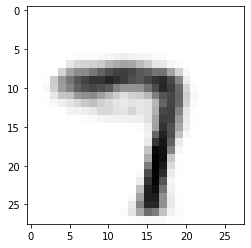

In [ ]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([5, 0.0]).to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()